In [1]:
# We will plot some information regarding volume levels on the raw gunshot and background sound datasets
# There is concern that some audio samples are excessively loud and possibly unrealistic, which leads to incorrect classification
from pydub import AudioSegment
import numpy as np
from math import sqrt, log10
import matplotlib.pyplot as plt

BACKGROUND_INDEX = 'data/raw_backgrounds_index.csv'
GUNSHOT_INDEX = 'data/raw_gunshots_index.csv'

MAX_32_SIGNED_INT = (2**31) -1 
MAX_16_SIGNED_INT = (2**15) -1
MAX_8_SIGNED_INT = (2**7) - 1
SCALE_16 = MAX_32_SIGNED_INT // MAX_16_SIGNED_INT # check compute_db_levels too
SCALE_8 = MAX_32_SIGNED_INT // MAX_8_SIGNED_INT # check compute_db_levels too
SHIFT_AMOUNT = abs(20*log10(1/MAX_32_SIGNED_INT)) # check compute_db_levels impl for explanation

DEBUG_PATH='/home/joao/dev/data/shotspotter/sortedBackground/162134-7-14-2.wav'

# good ones to test
# 162134-7-14-2.wav - loud jackhammer
# 159751-8-0-5.wav - not super loud ambulance

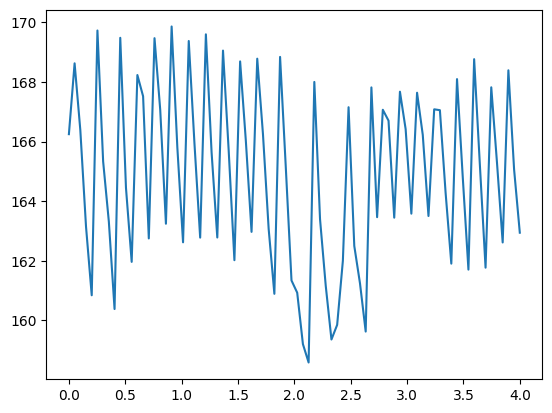

In [2]:
# function to compute db levels every 50ms worth of samples for a wav file
def compute_db_levels(path_to_wav, plot=True):
    #audio = AudioSegment.from_file(DEBUG_PATH, format="wav", codec="pcm_s32le")
    audio = AudioSegment.from_file(path_to_wav, format="wav")
        
    #print(path_to_wav)
    rate = audio.frame_rate
    samples = np.array(audio.get_array_of_samples())

    # we want to rescale 16/8 bit audio to 32 bit so we can accuractely compare them
    if audio.sample_width == 2:
        samples = samples.astype(np.int32) * SCALE_16
    elif audio.sample_width == 1:
        samples = samples.astype(np.int32) * SCALE_8
    
    # get sample rate per 50ms
    rate_50ms = rate//20
    db_levels = []
    for i in range(int(audio.duration_seconds*rate//rate_50ms)):
        samples_50ms = samples[i*rate_50ms:i*rate_50ms+rate_50ms].astype(np.float64)
    
        # note: we can use max 32 signed or max of our sample as reference
        # convert to dB use RMS and dB ratio formula
        db_levels.append(20*log10(sqrt(np.mean(np.square(samples_50ms))+1)/MAX_32_SIGNED_INT))

    # We use dB = 20*log10(RMS/REFERENCE) to compute db scale
    # since our REFERENCE is the max value for a sample, we will always get a log10(x) where x <= 1
    # this means that the highest dB is 0, and the lowest is computed at SHIFT_AMOUNT
    # we shift it for convenience and visualization (so our lowest is now 0)
    db_levels = [i+SHIFT_AMOUNT for i in db_levels]
    
    if plot:
        plt.plot(np.linspace(0, audio.duration_seconds, len(db_levels)), db_levels)

    return db_levels

compute_db_levels(DEBUG_PATH);

In [3]:
def read_from_index(path):
    result = []
    file_names = []
    with open(path, 'r') as f:
        for line in f.readlines():
            try:
                result.append(compute_db_levels(line.replace('\n',''), plot=False))
                file_names.append(line.replace('\n', ''))
            except:
                print('skipping anomaly')

    return (result, file_names)

averages, file_names = read_from_index(BACKGROUND_INDEX);
print('done')

skipping anomaly
skipping anomaly
skipping anomaly
skipping anomaly
skipping anomaly
skipping anomaly
skipping anomaly
skipping anomaly
skipping anomaly
done


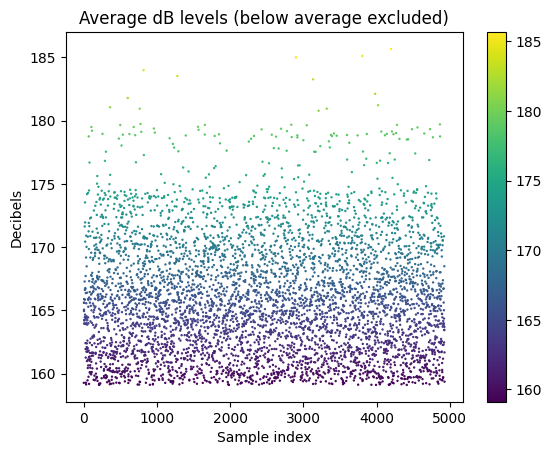

In [5]:
overall_averages = np.asarray([sum(a)/len(a) for a in averages])
# we will use total average of all our audio samples just to exclude the small values and better visualize extreme outliers
total_avg = sum(overall_averages)/len(overall_averages)
threshold = overall_averages > total_avg

filtered_averages = overall_averages[threshold]
plt.ylabel('Decibels')
plt.xlabel('Sample index')
plt.title('Average dB levels (below average excluded)')
plt.scatter(np.linspace(0, len(filtered_averages), len(filtered_averages)), filtered_averages, s=0.5, c=filtered_averages, cmap='viridis')
plt.colorbar()

In [14]:
# Based on the graph above, let's suppose a cutoff for being considered extreme is above 174dB
# Get file names of our extreme samples
extreme_indexes = overall_averages > 174
file_names = np.asarray(file_names)
extreme_samples = file_names[extreme_indexes]
len(extreme_samples)

222

In [15]:
import shutil
for e in extreme_samples:
    shutil.copy(e.replace('\n', ''), '/home/joao/dev/data/shotspotter/extremes/')

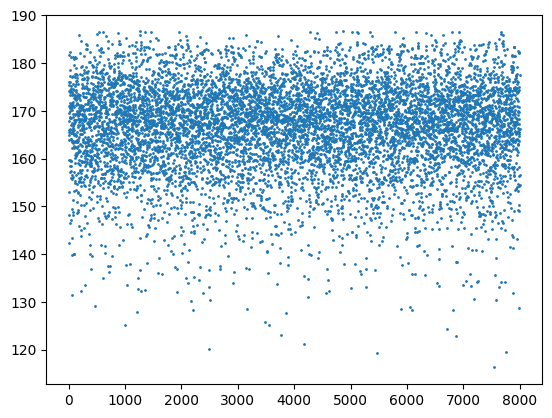

In [15]:
peak_averages = [max(a) for a in averages]

plt.scatter(np.linspace(0, 8000, len(averages)), peak_averages, s=1) #INVESTIGATE

In [20]:
# there is something wrong with the encoding of these files specifically, some of them can't be opened and played
# others have messed up "low resolution" audio

with open(BACKGROUND_INDEX, 'r') as f:
    for line in f.readlines():
        try:
            #print(line)
            audio = AudioSegment.from_file(line.replace('\n', ''), format="wav")
            #print(audio.sample_width)
        except:
            print('anomaly at' + line)

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/36429-2-0-6.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/36429-2-0-18.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/36429-2-0-7.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/88466-7-0-0.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/36429-2-0-14.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/36429-2-0-13.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/36429-2-0-15.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/19007-4-0-0.wav

anomaly at/home/joao/dev/data/shotspotter/sortedBackground/36429-2-0-23.wav



In [ ]:
print()